In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00


In [2]:

import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))


import re
from typing import Union, List

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:

class CleanText():
    """ clearing text except digits () . , word character """

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> str:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        # Join the list of lists into a single string
        text = ' '.join([' '.join(sents) for sents in text])

        return text


In [4]:

def remove_emoji(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


In [5]:

def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))


In [6]:
def remove_punct(text):
    text = regex.sub(" ", text)
    return text

clean = CleanText()


In [7]:
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2


In [8]:
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"


In [9]:
df = pd.read_csv("../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv")



Saving tripadvisor_hotel_reviews.csv to tripadvisor_hotel_reviews.csv


In [10]:
print("df.columns: ", df.columns)


df.columns:  Index(['Review', 'Rating'], dtype='object')


In [12]:
fig = px.histogram(df,
             x = 'Rating',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'Rating',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [14]:
df["label"] = df["Rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [15]:
df["Review"] = df["Review"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [16]:
df.head()

Review  Rating  label label_name
0      n       4      2   Positive
1      o       2      0   Negative
2      n       3      1    Neutral
3      u       5      2   Positive
4      g       5      2   Positive

In [17]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=df.label_name.value_counts().index,
                             values=df.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df.label_name.value_counts().index, y=df.label.value_counts().values, marker_color = colors), 1,2)

fig.show()

In [18]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [19]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [20]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True
    return_attention_mask=True
    pad_to_max_length=True
    do_lower_case=False
    return_tensors='pt'
config = Config()

In [21]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs,
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [22]:
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

In [23]:
df.head()

Review  Rating  label label_name
0      n       4      2   Positive
1      o       2      0   Negative
2      n       3      1    Neutral
3      u       5      2   Positive
4      g       5      2   Positive

In [24]:
from sklearn.model_selection import train_test_split

train_df_, val_df = train_test_split(df,
                                    test_size=0.10,
                                    random_state=config.random_state,
                            stratify=df.label.values)

In [25]:
train_df_.head()

Review  Rating  label label_name
8159       c       3      1    Neutral
15738      s       5      2   Positive
9972       n       5      2   Positive
7265       b       5      2   Positive
8747       n       4      2   Positive

In [26]:
train_df, test_df = train_test_split(train_df_,
                                    test_size=0.10,
                                    random_state=42,
                            stratify=train_df_.label.values)

In [27]:
print(len(train_df['label'].unique()))
print(train_df.shape)

3
(16596, 4)


In [28]:
print(len(val_df['label'].unique()))
print(val_df.shape)

3
(2050, 4)


In [29]:
print(len(test_df['label'].unique()))
print(test_df.shape)

3
(1845, 4)


In [30]:
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model,
                                          do_lower_case=config.do_lower_case)

In [31]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_df.Review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    val_df.Review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [32]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [33]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [34]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [35]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=config.batch_size)

In [36]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr,
                  eps=config.eps)


scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

In [ ]:
# Importer AutoTokenizer et AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Charger le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained("Group209/Sentiment_Analysis")
model = AutoModelForSequenceClassification.from_pretrained("Group209/Sentiment_Analysis")

# Faire une prédiction sur un exemple de texte
def predict_sentiment(text):
    # Prétraitement du texte
    encoded_input = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(config.device)

    # Passer le texte par le modèle
    model = model.to(config.device)
    with torch.no_grad():
        output = model(**encoded_input)

    # Obtenir les prédictions
    predictions = output.logits.argmax(dim=1)
    
    return label2name(predictions.item())  # Transformer l'étiquette numérique en nom d'étiquette

# Exemple d'utilisation
text = "Exemple de texte à classer"
print(predict_sentiment(text))


In [37]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')


In [38]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [39]:
config.device

device(type='cuda', index=0)

In [44]:
model.to(config.device)

for epoch in tqdm(range(1, config.epochs+1)):

    model.train()

    loss_train_total = 0
    # allows you to see the progress of the training
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)

    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(config.device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')

    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs
with Path('params.json').open("w") as f:
      json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2766 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7178085644150979
Validation loss: 0.6924614285865025
F1 Score (Weighted): 0.6362306487034783


Epoch 2:   0%|          | 0/2766 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7079535155319383
Validation loss: 0.7042874742887522
F1 Score (Weighted): 0.6480965005181274


Epoch 3:   0%|          | 0/2766 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.701972181601039
Validation loss: 0.6839241052580158
F1 Score (Weighted): 0.6480965005181274


Epoch 4:   0%|          | 0/2766 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6988462540479303
Validation loss: 0.6924292112738766
F1 Score (Weighted): 0.6480965005181274


Epoch 5:   0%|          | 0/2766 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6967607160500875
Validation loss: 0.6892623631882737
F1 Score (Weighted): 0.6485597934801345


In [45]:
model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [46]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

              precision    recall  f1-score   support

           0       0.09      0.49      0.15        57
           1       0.00      0.00      0.00         0
           2       0.98      0.75      0.85      1993

    accuracy                           0.74      2050
   macro avg       0.36      0.41      0.33      2050
weighted avg       0.96      0.74      0.83      2050



In [47]:
pred_final = []

for i, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']


    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/2050 [00:00<?, ?it/s]

In [ ]:
val_df["pred"] = pred_final
#  Add control column for easier wrong and right predictions
control = val_df.pred.values == val_df.label.values
val_df["control"] = control
# filtering false predictions
val_df = val_df[val_df.control == False]

In [ ]:
name2label = {"Negative":0,
              "Neutral":1,
             "Positive":2
             }
label2name = {v: k for k, v in name2label.items()}

val_df["pred_name"] = val_df.pred.apply(lambda x: label2name.get(x))
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = val_df.pred_name.values
label_values = val_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [50]:
confmat

array([[  0,   0, 295],
       [  5,   0, 213],
       [ 21,   0,   0]])

In [51]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0     Negative  Positive
row_0                       
Negative         0       295
Neutral          5       213
Positive        21         0

In [52]:
df_confusion_val.to_csv("val_df_confusion.csv")

In [53]:
test_df.head()

Review  Rating  label label_name
2298       g       4      2   Positive
9503       w       5      2   Positive
14742      b       3      1    Neutral
4140       c       2      0   Negative
3552       n       3      1    Neutral

In [54]:
encoded_data_test = tokenizer.batch_encode_plus(
    test_df.Review.values,
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
)
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)

In [55]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(config.device)

model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions_test, true_vals_test = evaluate(dataloader_validation)
# accuracy_per_class(predictions, true_vals, intent2label)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
def predict_sentiment(text):
    # Prétraitement du texte
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=config.add_special_tokens,
        return_attention_mask=config.return_attention_mask,
        pad_to_max_length=config.pad_to_max_length,
        max_length=config.seq_length,
        return_tensors=config.return_tensors
    )

    # Convertir les entrées en tenseurs et les déplacer vers le bon appareil
    input_ids = encoded_text['input_ids'].to(config.device)
    attention_mask = encoded_text['attention_mask'].to(config.device)

    # Mettre le modèle en mode d'évaluation et obtenir les prédictions
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)

    # Obtenir la prédiction du modèle
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()

    # Extraire la classe avec la probabilité la plus élevée
    pred = np.argmax(logits, axis=1).flatten()[0]

    # Convertir le label numérique en son nom correspondant
    pred_name = label2name.get(pred)

    return pred_name


In [65]:
text = "I hate you"
prediction = predict_sentiment(text)
print(f"The sentiment of the text is: {prediction}")


The sentiment of the text is: Positive


In [ ]:
from sklearn.metrics import classification_report

preds_flat_test = np.argmax(predictions_test, axis=1).flatten()
print(classification_report(preds_flat_test, true_vals_test))

In [ ]:
pred_final = []

for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    predictions = []

    review = row["Review"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review],
    add_special_tokens=config.add_special_tokens,
    return_attention_mask=config.return_attention_mask,
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

In [ ]:
# add pred into test
test_df["pred"] = pred_final
#  Add control column for easier wrong and right predictions
control = test_df.pred.values == test_df.label.values
test_df["control"] = control
# filtering false predictions
test_df = test_df[test_df.control == False]
test_df["pred_name"] = test_df.pred.apply(lambda x: label2name.get(x))

In [ ]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = test_df.pred_name.values
label_values = test_df.label_name.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))
confmat

In [ ]:
df_confusion_test = pd.crosstab(label_values, pred_name_values)
df_confusion_test

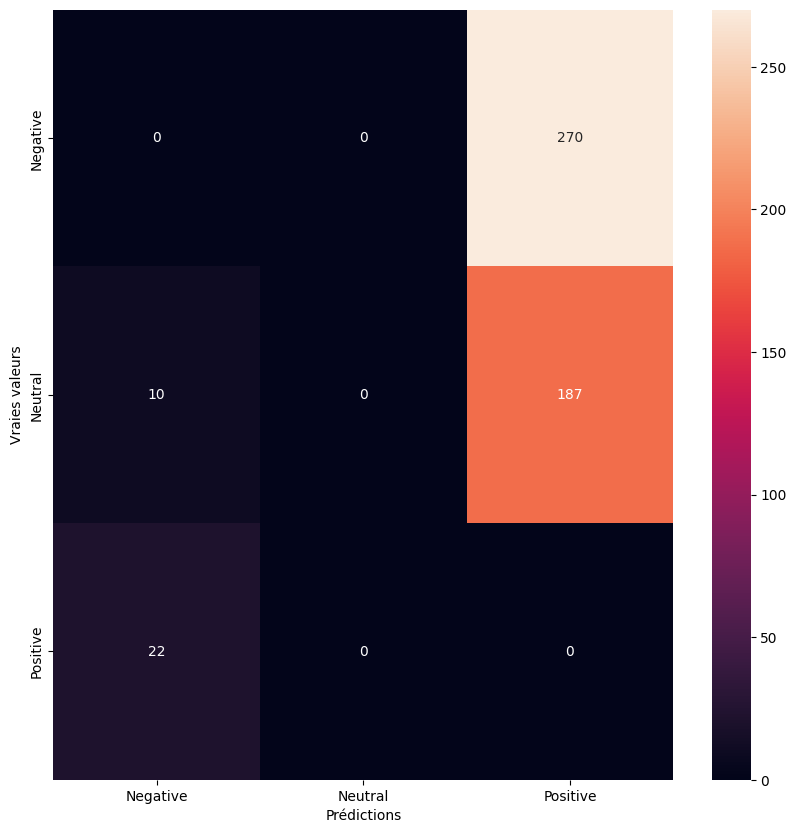

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(10,10))  # changez la taille selon vos besoins
sns.heatmap(confmat, annot=True, fmt='d',
            xticklabels=name2label.keys(), yticklabels=name2label.keys())
plt.ylabel('Vraies valeurs')
plt.xlabel('Prédictions')
plt.show()
